In [131]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import skorch
import numpy as np

from torch.autograd import Variable

In [132]:
%matplotlib inline
from matplotlib import pyplot as plt

In [133]:
def repeat_and_mark(x, rep=2, mark=True):
    o = torch.zeros(*x.shape[:-1], 1).to(x)
    x_mark = torch.cat([x, o], dim=-1)
    xx_pre = x_mark[:, :, None, :].repeat(1, 1, rep, 1)
    if mark:
        # mark beginning of repetitions with 1
        xx_pre[:, :, 0, -1] = 1
    return xx_pre.view(x_mark.shape[0], x_mark.shape[1]*rep, x_mark.shape[2])

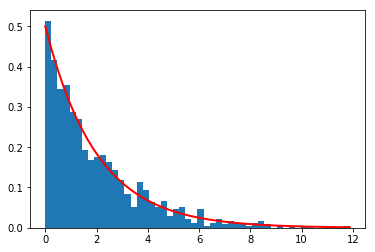

In [134]:
shape, scale = 1., 2.  # mean=2, std=2*sqrt(1)
s = np.random.gamma(shape, scale, 1000)

import matplotlib.pyplot as plt
import scipy.special as sps
count, bins, ignored = plt.hist(s, 50, normed=True)
y = bins**(shape-1)*(np.exp(-bins/scale) /
                      (sps.gamma(shape)*scale**shape))
plt.plot(bins, y, linewidth=2, color='r')
plt.show()

In [135]:
s.mean(), s.std(), 2*np.sqrt(1)

(1.9464693413885592, 1.8625110833168257, 2.0)

(array([400., 228., 153.,  86.,  57.,  32.,  19.,  11.,   9.,   2.,   2.,
          1.]),
 array([ 0.        ,  0.91666667,  1.83333333,  2.75      ,  3.66666667,
         4.58333333,  5.5       ,  6.41666667,  7.33333333,  8.25      ,
         9.16666667, 10.08333333, 11.        ]),
 <a list of 12 Patch objects>)

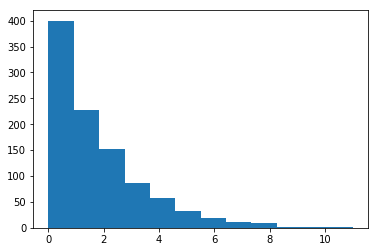

In [136]:
plt.hist(s.astype('int32'), bins=12)

In [137]:
t = torch.FloatTensor([10])

In [138]:
from functools import reduce

In [139]:
def ema(x, a):
    return reduce(lambda y, x: a * x + (1-a)*y, x, 0)

In [140]:
def sema(x, a):
    return np.array([ema(x[:i], a) for i, _ in enumerate(x)])

In [141]:
def ssema(x, a):
    return np.array([ema(x[:i], a[i]) for i, _ in enumerate(x)])

In [142]:
def upcay(x, a, q=0.1):
    a = max(0, a)
    return reduce(lambda y, _: q if (y * a) > 1 else (y * a), x, q)
def supcay(x, a, q=0.1):
    return np.array([upcay(x[:i], a=a, q=q) for i, _ in enumerate(x)])

In [143]:
def decay(x, a, q=1):
    if a == 0: return 0
    return reduce(lambda y, _: q if y < 0.01 else (y * a), x, q)
def sdecay(x, a, q=1):
    return np.array([decay(x[:i], a=a, q=q) for i, _ in enumerate(x)])

In [144]:
def ecay(x, f, q=0.1):
    return reduce(f, x, q)
def secay(x, f, q=0.1):
    return np.array([ecay(x[:i], f, q=q) for i, _ in enumerate(x)])

In [145]:
def modupcay(x, a, q=0.1):
    return reduce(lambda y, _: (y * a), x, q)
def smodupcay(x, a, q=0.1):
    return np.array([modupcay(x[:i], a=a, q=q) for i, _ in enumerate(x)])

In [146]:
x = np.arange(0, 20)
decay(x, 0.4)
sdecay(x, 0.0, q=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [147]:
x = np.arange(0, 20)
smodupcay(x, 1.3, q=1)

array([  1.        ,   1.3       ,   1.69      ,   2.197     ,
         2.8561    ,   3.71293   ,   4.826809  ,   6.2748517 ,
         8.15730721,  10.60449937,  13.78584918,  17.92160394,
        23.29808512,  30.28751066,  39.37376386,  51.18589301,
        66.54166092,  86.50415919, 112.45540695, 146.19202904])

In [148]:
x = np.arange(0, 20)
upcay(x, 1.1)
supcay(x, 1.1, q=0.1)

array([0.1       , 0.11      , 0.121     , 0.1331    , 0.14641   ,
       0.161051  , 0.1771561 , 0.19487171, 0.21435888, 0.23579477,
       0.25937425, 0.28531167, 0.31384284, 0.34522712, 0.37974983,
       0.41772482, 0.4594973 , 0.50544703, 0.55599173, 0.6115909 ])

In [149]:
def softmod1(x):
    cot = lambda x: 1/np.tan(x)
    a = p = 1
    return (1 - (2*a / np.pi * np.arctan(cot(x * np.pi / p))))/2

In [150]:
softmod1(0.9)

0.9

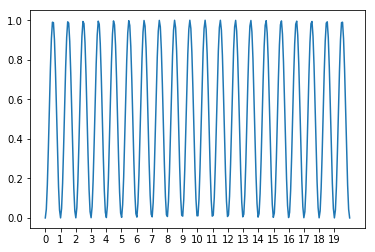

In [151]:
xi = np.linspace(0, 20, 300)
#xi = np.arange(0, 20)
y = (np.sin(xi/1 * 2 * np.pi - np.pi/2) + 1) / 2
plt.plot(xi, y)
plt.xticks(np.arange(xi.max()));

In [152]:
softmod1(49.9999)

0.9998999999999962

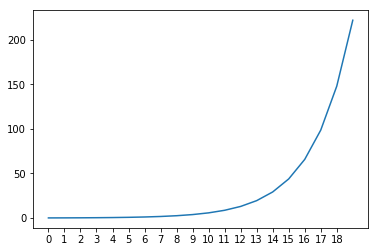

In [153]:
#xi = np.linspace(0, 20, 1000)
xi = np.arange(0, 20) - 0.001
y = smodupcay(xi, 1.5, q=0.1)
#y = softmod1(xi+1)
plt.plot(xi, y,)
plt.xticks(np.arange(max(xi)));

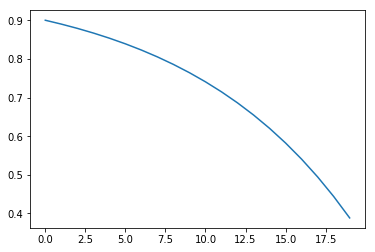

In [154]:
#xi = np.linspace(0, 20, 300)
xi = np.arange(0, 20)
y = 1 - supcay(xi, 1.1, q=0.1)
#y = supcay(xi, 1.2, q=0.1)
plt.plot(xi, y)

In [155]:
softmod1(1.01)

0.009999999999999842

In [156]:
def softmod1_asq(x):
    xi = x * 2*np.pi - np.pi + 0.4
    y = np.sin(xi) - 1/2 * np.sin(2*xi) + 1/3 * np.sin(3*xi) - 1/4*np.sin(4*xi) + 1/5*np.sin(5*xi) - 1/6*np.sin(6*xi)
    return (y + 3/2) / 3

In [157]:
softmod1_asq(0.03)

0.0008891891681736356

In [158]:
def softmod1_naive(x):
    return 0.01 if x > 1 else x

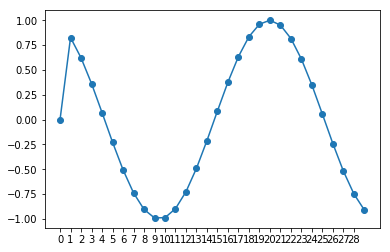

In [159]:
#xi = np.linspace(0, 2, 300)
xi = np.arange(0, 30)
tmp = 0
def meh(x, a=1.71, q=0.1):
    global tmp 
    tmp += a
    f = lambda y, _: np.cos(tmp)
    return reduce(f, x, q)
def smeh(x, a, q=0.1):
    global tmp
    tmp = q
    return np.array([meh(x[:i], a, q=q) for i, _ in enumerate(x)])
y1 = smeh(xi, a=0.3, q=0.0)
#y2 = smeh(xi, a=1.76, q=0.0)
#y = np.cos(xi)
#y = approx_sq(xi.copy().astype('float32'))
#y = softmod1_asq(xi)
plt.plot(xi, y1, 'o-')
#plt.plot(xi, y2, 'o-')
plt.xticks(np.arange(max(xi)));

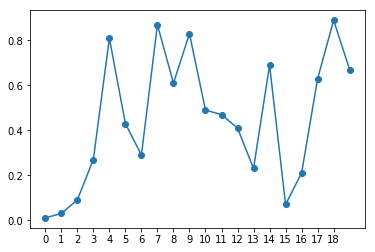

In [160]:
#xi = np.linspace(0, 2, 300)
relu = lambda x: max(0, x)
xi = np.arange(0, 20)
#y = sdecay(xi, 0.01, q=1)
a = 3
def test(y, _):
    #print(y, ' -> ', y*a)
    #return 0.01 if y > 1 else y * a
    return softmod1(y * a)
    return softmod1_naive(y * a)
y = secay(xi, test, q=0.01)
def approx_sq(xi):
    xi /= 1
    xi *= 2*np.pi
    xi -= np.pi - 0.4
    y = np.sin(xi) - 1/2 * np.sin(2*xi) + 1/3 * np.sin(3*xi) - 1/4*np.sin(4*xi) + 1/5*np.sin(5*xi) - 1/6*np.sin(6*xi)
    y += 3/2
    y /= 3
    return y
#y = approx_sq(xi.copy().astype('float32'))
#y = softmod1_asq(xi)
plt.plot(xi, y, 'o-')
plt.xticks(np.arange(max(xi)));

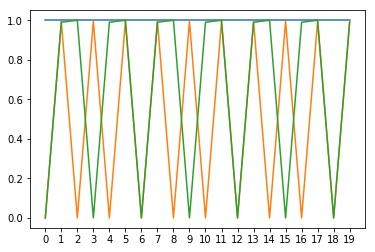

In [161]:
#xi = np.linspace(0, 20, 300)
xi = np.arange(0, 20)
y = 1 - sdecay(xi, 0.00, q=1)
plt.plot(xi, y)
y = 1 - sdecay(xi, 0.005, q=1)
plt.plot(xi, y)
y = 1 - sdecay(xi, 0.01, q=1)
plt.plot(xi, y)
plt.xticks(xi);

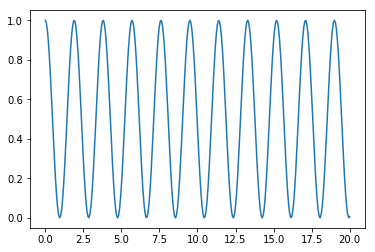

In [162]:
xi = np.linspace(0, 20, 300)
#xi = np.arange(0, 20)
y = ((np.cos(xi/1.9 * np.pi * 2)+1)/2)
plt.plot(xi, y)

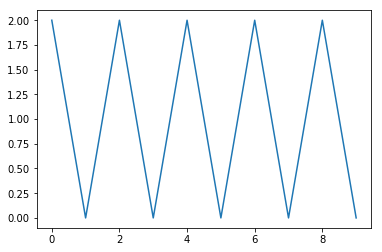

In [163]:
ti = np.arange(0, 10)
y = np.cos(ti/2 * np.pi * 2 ) + 1
plt.plot(ti, y)

/home/nemo/Code/pytorch/envs/skorch/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


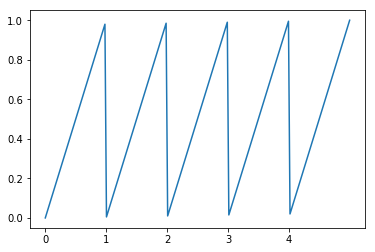

In [164]:
cot = lambda x: 1/np.tan(x)
xi = np.linspace(0, 5, 200)
p = 1
a = 1
y = (1 - (2*a / np.pi * np.arctan(cot(xi * np.pi / p))))/2
plt.plot(xi, y)
plt.xticks(np.arange(max(xi)));

### Experiment with own switch op

In [165]:
# q if (y * a) > 1 else (y * a)
class __DecaySwitchOp(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, x, q, a, n):
        ctx.save_for_backward(x, q, a, n)
        if x > 1:
            return q
        return x * a
    
    @staticmethod
    def backward(self, grad_out):
        grad_x = 0
        grad_q = 0
        grad_a = 0
        return grad_x, grad_q, grad_a

In [263]:
# q if (y * a) > 1 else (y * a)
class DecaySwitchOp(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, y, q):
        ctx.save_for_backward(y)
        ctx.mask = (y > 1)
        ctx.q = q
        yn = y.clone() # clone to make a new op in the graph
        yn[ctx.mask] = q
        return yn
    
    @staticmethod
    def backward(ctx, grad_out):
        y, = ctx.saved_tensors      
        grad_y, grad_q = None, None
        
        if ctx.needs_input_grad[0]:
            mask = ctx.mask
            grad_y = torch.ones_like(y)
            #grad_y[mask] = 1/100
            grad_y = grad_out * grad_y
            grad_y[mask] = 0.1
        
        if ctx.needs_input_grad[1]:
            grad_q = 0

        return grad_y, grad_q

In [264]:
dso = DecaySwitchOp.apply

In [236]:
#t = torch.FloatTensor([0.5,1,2])
a = torch.FloatTensor([1.1, 1.5])
a.requires_grad = True
t = torch.FloatTensor([0.1, 0.1])
#t = skorch.utils.to_var(t, False)
#t.requires_grad = True
# q = torch.FloatTensor([0.1])
# q = skorch.utils.to_var(q, False)

In [237]:
for i in range(100):
    t = dso(t * a, 0.1)
t

tensor([ 0.1000,  0.5063])

In [238]:
t.sum().backward()

In [239]:
a.grad

tensor([ 9.8497,  8.6400])

### Modules

In [240]:
class InternalClocking(nn.Module):
    def __init__(self, input_dim, hidden_dim, act='tanh', non_linear_state=False):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.non_linear_state = non_linear_state
        
        self.i2h = nn.Linear(input_dim, hidden_dim)
        self.h2h = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.speed = nn.Parameter(torch.ones(hidden_dim))
        self.act = {'relu': nn.ReLU, 'tanh': nn.Tanh}[act]()
        
    def reset_weights(self):
        torch.nn.init.uniform_(self.speed.data, 0, 5)
        
        # IRNN init
        torch.nn.init.normal_(self.i2h.weight.data, mean=0, std=0.001)
        self.i2h.bias.data.zero_()
        torch.nn.init.eye_(self.h2h.weight.data)
        
    def forward(self, x, h=None): # x is (b, t, u) 
        if h is None:
            h = torch.zeros(self.hidden_dim).to(x)
            
        i2h = self.i2h(x.view(-1, self.input_dim))
        i2h = i2h.view(x.size(0), x.size(1), self.hidden_dim)
        
        tick = torch.zeros(self.hidden_dim).to(x)
            
        ys = []
        cs = []
        for ti in range(x.size(1)):
            #clock_gate = tick % 1
            tick = tick + self.speed
            clock_gate = (torch.cos(tick) + 1) / 2

            if self.non_linear_state:
                h_new = self.act(i2h[:, ti] + self.h2h(h))
                y = clock_gate * h_new + (1 - clock_gate) * h
                h = y
            else:
                h_new = i2h[:, ti] + self.h2h(h)
                h = clock_gate * h_new + (1 - clock_gate) * h
                y = self.act(h)
                            
            ys.append(y)
            cs.append(clock_gate)
        return torch.stack(ys, dim=1), h, torch.stack(cs, dim=0)

In [241]:
class DecayClocking(nn.Module):
    def __init__(self, input_dim, hidden_dim, act='tanh', non_linear_state=False):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.non_linear_state = non_linear_state
        
        self.i2h = nn.Linear(input_dim, hidden_dim)
        self.h2h = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.alpha = nn.Parameter(torch.zeros(hidden_dim))
        self.act = {'relu': nn.ReLU, 'tanh': nn.Tanh}[act]()
        
    def reset_weights(self):
        torch.nn.init.uniform_(self.alpha.data, 1, 2)
        torch.nn.init.normal_(self.i2h.weight.data, mean=0, std=0.001)
        self.i2h.bias.data.zero_()
        torch.nn.init.eye_(self.h2h.weight.data)
        
    def forward(self, x, h=None): # x is (b, t, u) 
        if h is None:
            h = torch.zeros(self.hidden_dim).to(x)
            
        i2h = self.i2h(x.view(-1, self.input_dim))
        i2h = i2h.view(x.size(0), x.size(1), self.hidden_dim)

        q = 0.1
        decay = torch.zeros(self.hidden_dim).to(x) + q
            
        ys = []
        cs = []
        y = h
        for ti in range(x.size(1)):
            """
            decay = decay * self.alpha
            mask = (decay >= 1).long().nonzero()
            decay.index_add_(0, mask, -1)
            """
            # Remarkable: Using the exponential formula achieved
            # the best result yet (MAE < 0.1) even though it is
            # not periodical (depending on alpha the neuron is
            # only active for a certain time of the sequence.
            # This might be worth following up on.
            #decay = dso(q * F.relu(self.alpha)**ti, q)
            decay = dso(decay * F.relu(self.alpha), q)
            clock_gate = 1 - decay

            if self.non_linear_state:
                h_new = self.act(i2h[:, ti] + self.h2h(h))
                y = clock_gate * h_new + (1 - clock_gate) * h
                h = y
            else:
                h_new = i2h[:, ti] + self.h2h(y)
                h = clock_gate * h_new + (1 - clock_gate) * h
                y = self.act(h)
            ys.append(y)
            cs.append(clock_gate)
        return torch.stack(ys, dim=1), h, torch.stack(cs, dim=0)

In [242]:
class Clocking(nn.Module):
    def __init__(self, input_dim, hidden_dim, act='tanh', non_linear_state=False):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.non_linear_state = non_linear_state
        
        self.i2h = nn.Linear(input_dim, hidden_dim)
        self.h2h = nn.Linear(hidden_dim, hidden_dim, bias=False)
        #self.period = nn.Parameter(torch.randn(hidden_dim) + 1)
        self.period = nn.Parameter(torch.ones(hidden_dim))
        self.act = {'relu': nn.ReLU, 'tanh': nn.Tanh}[act]()
        
    def reset_weights(self):
        #self.period.data.set_(1)
        shape, scale = 1., 2.  # mean=2, std=2*sqrt(2)
        s = np.random.gamma(shape, scale, self.hidden_dim) + 1
        s = s.astype('int32').astype('float32') # quantize
        self.period.data.set_(torch.from_numpy(s))

        # IRNN init
        torch.nn.init.normal_(self.i2h.weight.data, mean=0, std=0.001)
        self.i2h.bias.data.zero_()
        torch.nn.init.eye_(self.h2h.weight.data)
        
    def forward(self, x, clock=None, h=None): # x is (b, t, u) 
        if h is None:
            h = torch.zeros(self.hidden_dim).to(x)
            
        i2h = self.i2h(x.view(-1, self.input_dim))
        i2h = i2h.view(x.size(0), x.size(1), self.hidden_dim)
            
        ys = []
        cs = []
        for ti in range(x.size(1)):
            clock_gate = (torch.cos(ti/self.period * np.pi * 2) + 1) / 2
            # enable stacking of clocking functions
            if clock is not None:
                clock_gate = (clock_gate + clock[ti]) / 2

            if self.non_linear_state:
                h_new = self.act(i2h[:, ti] + self.h2h(h))
                y = clock_gate * h_new + (1 - clock_gate) * h
                h = y
            else:
                h_new = i2h[:, ti] + self.h2h(h)
                h = clock_gate * h_new + (1 - clock_gate) * h
                y = self.act(h)
            ys.append(y)
            cs.append(clock_gate)
        return torch.stack(ys, dim=1), h, torch.stack(cs, dim=0)

In [243]:
class GaussClocking(nn.Module):
    def __init__(self, input_dim, hidden_dim, act='tanh', repeats=2, 
                 mark_repeats=True, non_linear_state=False,
                ):
        super().__init__()

        self.input_dim = input_dim #+ 1
        self.hidden_dim = hidden_dim
        self.repeats = repeats
        self.mark_repeats = mark_repeats
        self.non_linear_state = non_linear_state
        
        self.i2h = nn.Linear(self.input_dim, hidden_dim)
        self.h2h = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.m = nn.Parameter(torch.ones(hidden_dim) - 0.5)
        self.s = nn.Parameter(torch.ones(hidden_dim))
        self.act = {'relu': nn.ReLU, 'tanh': nn.Tanh}[act]()
        
    def reset_weights(self):
        torch.nn.init.uniform_(self.m.data, 0, 1)
        torch.nn.init.uniform_(self.s.data, 0.01, 0.1)
        
        # IRNN init
        torch.nn.init.normal_(self.i2h.weight.data, mean=0, std=0.001)
        self.i2h.bias.data.zero_()
        torch.nn.init.eye_(self.h2h.weight.data)
        
    def forward(self, x, h=None): # x is (b, t, u) 
        if h is None:
            h = torch.zeros(self.hidden_dim).to(x)
            
        xr = x#repeat_and_mark(x, rep=self.repeats, mark=self.mark_repeats)
        i2h = self.i2h(xr.view(-1, self.input_dim))
        i2h = i2h.view(xr.size(0), xr.size(1), self.hidden_dim)

        clks = torch.randn(xr.size(1), self.hidden_dim).to(x)
        clks = F.sigmoid(clks * self.s + self.m)
        
        ys = []
        cs = []
        for ti in range(xr.size(1)):
            clock_gate = clks[ti]
            h_new = i2h[:, ti] + self.h2h(h)
            if self.non_linear_state:
                y = clock_gate * self.act(h_new) + (1 - clock_gate) * h
                h = y
            else:
                h = clock_gate * h_new + (1 - clock_gate) * h
                y = self.act(h)
            ys.append(y)
            cs.append(clock_gate)
        return torch.stack(ys, dim=1), h, torch.stack(cs, dim=0)

In [244]:
class IRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, act='tanh', repeats=2, 
                 mark_repeats=True, non_linear_state=False,
                ):
        super().__init__()

        self.input_dim = input_dim #+ 1
        self.hidden_dim = hidden_dim
        self.repeats = repeats
        self.mark_repeats = mark_repeats
        self.non_linear_state = non_linear_state
        
        self.i2h = nn.Linear(self.input_dim, hidden_dim)
        self.h2h = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.act = {'relu': nn.ReLU, 'tanh': nn.Tanh}[act]()
        
    def reset_weights(self):        
        # IRNN init
        torch.nn.init.normal_(self.i2h.weight.data, mean=0, std=0.001)
        self.i2h.bias.data.zero_()
        torch.nn.init.eye_(self.h2h.weight.data)
        
    def forward(self, x, h=None): # x is (b, t, u) 
        if h is None:
            h = torch.zeros(self.hidden_dim).to(x)
            
        xr = x#repeat_and_mark(x, rep=self.repeats, mark=self.mark_repeats)
        i2h = self.i2h(xr.view(-1, self.input_dim))
        i2h = i2h.view(xr.size(0), xr.size(1), self.hidden_dim)

        ys = []
        cs = []
        for ti in range(xr.size(1)):
            h_new = i2h[:, ti] + self.h2h(h)
            if self.non_linear_state:
                y =  self.act(h_new)
                h = y
            else:
                h = h_new
                y = self.act(h)
            ys.append(y)
            cs.append(y)
        return torch.stack(ys, dim=1), h, torch.stack(cs, dim=0)

In [245]:
class GaussInputClocking(nn.Module):
    def __init__(self, input_dim, hidden_dim, act='tanh', non_linear_state=False):
        super().__init__()

        self.input_dim = input_dim #+ 1
        self.hidden_dim = hidden_dim
        self.non_linear_state = non_linear_state
        
        self.i2h = nn.Linear(self.input_dim, hidden_dim)
        self.h2h = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.i2c = nn.Linear(self.input_dim, 2 * hidden_dim)
        self.act = {'relu': nn.ReLU, 'tanh': nn.Tanh}[act]()
        
    def reset_weights(self):
        #torch.nn.init.uniform_(self.m.data, 0, 1)
        #torch.nn.init.uniform_(self.s.data, 0.01, 0.1)
        #self.i2c.reset_parameters()
        #self.i2h.reset_parameters()
        torch.nn.init.uniform_(self.i2c.bias.data[:self.hidden_dim], 0, 1)
        torch.nn.init.uniform_(self.i2c.bias.data[self.hidden_dim:], 0.01, 0.5)
        
    def forward(self, x, h=None): # x is (b, t, u) 
        if h is None:
            h = torch.zeros(self.hidden_dim).to(x)
            
        xr = x
        i2h = self.i2h(xr.view(-1, self.input_dim))
        i2h = i2h.view(xr.size(0), xr.size(1), self.hidden_dim)
        
        i2c = self.i2c(xr.view(-1, self.input_dim))
        i2c = i2c.view(xr.size(0), xr.size(1), 2 * self.hidden_dim)
        m = i2c[:, :, :self.hidden_dim]
        s = i2c[:, :, self.hidden_dim:]

        clks = torch.randn(xr.size(1), self.hidden_dim).to(x)
        clks = F.sigmoid(clks * s + m)
        
        ys = []
        cs = []
        for ti in range(xr.size(1)):
            clock_gate = clks[:, ti]
            h_new = i2h[:, ti] + self.h2h(h)
            if self.non_linear_state:
                y = clock_gate * self.act(h_new) + (1 - clock_gate) * h
                h = y
            else:
                h = clock_gate * h_new + (1 - clock_gate) * h
                y = self.act(h)
            ys.append(y)
            cs.append(clock_gate)
        return torch.stack(ys, dim=1), h, torch.stack(cs, dim=1)

In [246]:
import visdom
vis = visdom.Visdom()

In [247]:
def get_batch(batch_size, time_steps, random_state=0):
    """Generate the adding problem dataset"""
    rng = np.random.RandomState(seed=random_state)
    
    # Build the first sequence
    add_values = rng.rand(batch_size, time_steps)
    add_values = add_values.astype('float32')

    # Build the second sequence with one 1 in each half and 0s otherwise
    add_indices = np.zeros_like(add_values)
    half = int(time_steps / 2)
    for i in range(batch_size):
        first_half = rng.randint(half)
        second_half = rng.randint(half, time_steps)
        add_indices[i, [first_half, second_half]] = 1

    # Zip the values and indices in a third dimension:
    # inputs has the shape (batch_size, time_steps, 2)
    inputs = np.dstack((add_values, add_indices))
    targets = np.sum(np.multiply(add_values, add_indices), axis=1)
    return inputs, targets.reshape(-1, 1)

In [248]:
class AddDataset(torch.utils.data.Dataset):
    def __init__(self, n_timesteps, length=200, random_state=0):
        self.n_timesteps = n_timesteps
        self.length = length
        self.rng_ = np.random.RandomState(seed=random_state)
    def __getitem__(self, i):
        Xi, yi = get_batch(1, self.n_timesteps, random_state=self.rng_.randint(1e8))
        return Xi[0], yi[0]
    def __len__(self):
        return self.length

In [249]:
T = 100
#X_train, y_train = get_batch(2000, T, random_state=0)
X_valid, y_valid = get_batch(200, T, random_state=1)

In [250]:
dataset_train = AddDataset(n_timesteps=T, length=200)

In [251]:
for Xi, yi in zip(X_valid, y_valid):
    idcs = Xi[:, 1].nonzero()[0]
    assert np.allclose(Xi[idcs, 0].sum(), yi[0])

In [252]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

In [253]:
class ReconModel(nn.Module):
    def __init__(self, num_hidden=64, act='relu', repeats=2, mark_repeats=True, 
                 num_layers=1, visdom=False, rnn_type='gauss', non_linear_state=False,
                 learnable_mean=True):
        super().__init__()
        
        self.visdom = visdom
        self.rnn = []
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        
        for i in range(num_layers):
            input_dim = 2 if i == 0 else num_hidden
            output_dim = num_hidden
            #output_dim = 1 if i == (num_layers - 1) else num_hidden
            if rnn_type == 'gauss':
                self.rnn.append(GaussClocking(input_dim, output_dim, 
                                              repeats=repeats, mark_repeats=mark_repeats, 
                                              act=act, non_linear_state=non_linear_state))
                self.rnn[-1].reset_weights()
            elif rnn_type == 'gauss_input':
                self.rnn.append(GaussInputClocking(input_dim, output_dim, 
                                                   act=act, non_linear_state=non_linear_state))
                self.rnn[-1].reset_weights()
            elif rnn_type == 'irnn':
                self.rnn.append(IRNN(input_dim, output_dim, 
                                     repeats=repeats, mark_repeats=mark_repeats, 
                                     act=act, non_linear_state=non_linear_state))
                self.rnn[-1].reset_weights()
            elif rnn_type == 'clocking':
                self.rnn.append(Clocking(input_dim, output_dim, 
                                         act=act, non_linear_state=non_linear_state))
                self.rnn[-1].reset_weights()
            elif rnn_type == 'decay_clocking':
                self.rnn.append(DecayClocking(input_dim, output_dim, 
                                              act=act, non_linear_state=non_linear_state))
                self.rnn[-1].reset_weights()
            elif rnn_type == 'internal_clocking':
                self.rnn.append(InternalClocking(input_dim, output_dim, 
                                                 act=act, non_linear_state=non_linear_state))
                self.rnn[-1].reset_weights()
            elif rnn_type == 'gru':
                self.rnn.append(nn.GRU(input_dim, output_dim, batch_first=True))
            self.add_module('rnn'+str(i), self.rnn[-1])
        
        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        li = x
        self.cis = [None] * self.num_layers
        for i in range(self.num_layers):
            if self.rnn_type == 'gru':
                li, hi = self.rnn[i](li)
                ci = None
            else:
                li, hi, ci = self.rnn[i](li)
            self.cis[i] = ci
            if self.visdom:
                vis.heatmap(skorch.utils.to_numpy(li[0]), opts={'title': 'act rnn'+str(i)}, win="act rnn"+str(i))
                if ci is not None:
                    vis.heatmap(skorch.utils.to_numpy(ci), opts={'title': 'clocks rnn'+str(i)}, win="clocks rnn"+str(i))
        return self.clf(li[:, -1])

In [254]:
class Trainer(skorch.NeuralNet):
    def __init__(
        self, 
        criterion=nn.MSELoss,
        *args, 
        **kwargs
    ):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, training=False):
        if False:
            for Xi, yi in zip(X, y_true):
                sm = sum([Xi[i[0], 0] for i in Xi[:, 1].nonzero()])
                assert abs(sm - yi.item()) < 0.01
        return (y_pred - y_true).abs().mean(-1).mean()
        return super().get_loss(y_pred, y_true, X=X, training=training)

In [255]:
class GradLogger(skorch.callbacks.Callback):
    def __init__(self, param_pattern, debug_print=False):
        self.param_pattern = param_pattern
        self.to_accumulate_ = set()
        self.debug_print = debug_print
        
    def on_grad_computed(self, net, named_parameters, **kwargs):        
        from fnmatch import fnmatch
        param_pairs = filter(lambda x: fnmatch(x[0], self.param_pattern), named_parameters)
        for name, param in param_pairs:
            history_name = 'grad_' + name
            net.history.record_batch(history_name, param.grad.abs().mean().item())
            self.to_accumulate_.add(history_name)
            if self.debug_print:
                print(param.grad.data.tolist())
            
    def on_epoch_end(self, net, **kwargs):
        for name in self.to_accumulate_:
            mean = np.mean(net.history[-1, 'batches', :, name])
            net.history.record(name, mean)

In [256]:
class ParamLogger(skorch.callbacks.Callback):
    def __init__(self, param_pattern):
        self.param_pattern = param_pattern
        self.to_accumulate_ = set()
        
    def on_batch_end(self, net, **kwargs):        
        from fnmatch import fnmatch
        param_pairs = filter(lambda x: fnmatch(x[0], self.param_pattern), net.module_.named_parameters())
        for name, param in param_pairs:
            history_name = 'mean_' + name
            net.history.record_batch(history_name, param.mean().item())
            self.to_accumulate_.add(history_name)
            #print(param.data.tolist())
            
    def on_epoch_end(self, net, **kwargs):
        for name in self.to_accumulate_:
            mean = np.mean(net.history[-1, 'batches', :, name])
            net.history.record(name, mean)
            #print(dict(net.module_.named_parameters())[name[len('mean_'):]].data.tolist())

In [257]:
class ParamPrinter(skorch.callbacks.Callback):
    def __init__(self, param_pattern, mode='batch', format='{}'):
        self.param_pattern = param_pattern
        self.mode = mode
        self.format = format
        
    def print_params(self, net):
        from fnmatch import fnmatch
        param_pairs = filter(lambda x: fnmatch(x[0], self.param_pattern), net.module_.named_parameters())
        for name, param in param_pairs:
            print([self.format.format(n) for n in param.data.tolist()])
        
    def on_batch_end(self, net, **kwargs):        
        if self.mode != 'batch':
            return
        self.print_params(net)
            
    def on_epoch_end(self, net, **kwargs):
        if self.mode != 'epoch':
            return
        self.print_params(net)   

In [258]:
class QuantizeParameters(skorch.callbacks.Callback):
    def __init__(self, param_pattern):
        self.param_pattern = param_pattern
        
    def on_batch_begin(self, net, **kwargs):        
        from fnmatch import fnmatch
        param_pairs = filter(lambda x: fnmatch(x[0], self.param_pattern), net.module_.named_parameters())
        for name, param in param_pairs:
            self._quantize(param)
            
    def _quantize(self, param):
        #import pdb; pdb.set_trace()
        param.data.set_((param.data + 0.5).long().float())
        param.data[param.data == 0] = 1

In [265]:
torch.manual_seed(1333)

def my_train_split(ds, y):
    return ds, skorch.dataset.Dataset(X_valid, y_valid)

ef = Trainer(module=ReconModel,
             optimizer=torch.optim.RMSprop,
             lr=0.002,
             max_epochs=300,
             train_split=my_train_split,
             
             module__num_hidden=50,
             module__act='relu',
             module__num_layers=1,
             module__visdom=False,
             #module__rnn_type='internal_clocking',
             module__rnn_type='decay_clocking',
             #module__rnn_type='clocking',
             module__non_linear_state=False,
             
             #iterator_train=train_iterator,
             #iterator_train__n_batches=200,
             #iterator_train__n_timesteps=100,
             #iterator_train__shuffle=True,
             
             device='cpu',
             batch_size=16,
            
             optimizer__param_groups=[
                 ('rnn*.period', {'lr': 0.2}),
                 ('rnn*.speed', {'lr': 0.02}),
                 ('rnn*.alpha', {'lr': 0.0002}),
                 ('rnn*.s', {'lr': 0.02}),
             ],
             
             callbacks=[
                 #skorch.callbacks.ProgressBar(),
                 ('mae_valid', skorch.callbacks.EpochScoring(scoring='neg_mean_absolute_error', name='mae_valid', lower_is_better=False)),
                 ('mae_train', skorch.callbacks.EpochScoring(scoring='neg_mean_absolute_error', name='mae_train', lower_is_better=False, on_train=True)),
                 ('grad_log_1', GradLogger('rnn*.h2h.*')),
                 ('grad_log_3', GradLogger('rnn*.i2c.*')),
                 ('grad_log_2', GradLogger('rnn*.[ms]')),
                 ('grad_log_4', GradLogger('rnn*.period', debug_print=False)),
                 ('grad_log_5', GradLogger('rnn*.alpha', debug_print=False)),
                 ('grad_log_6', GradLogger('rnn*.speed', debug_print=False)),
                 ('mean_log_4', ParamLogger('rnn*.period')),
                 #('parm_log_1', ParamPrinter('rnn*.period', mode='epoch')),
                 #('parm_log_2', ParamPrinter('rnn*.alpha', mode='epoch', format='{:.3f}')),
                 #('parm_log_3', ParamPrinter('rnn*.speed', mode='epoch', format='{:.3f}')),
                 skorch.callbacks.GradientNormClipping(gradient_clip_value=10),
                 QuantizeParameters('rnn*.period'),
             ]
            )

In [ ]:
%pdb on
ef.fit(dataset_train)

Automatic pdb calling has been turned ON
  epoch    grad_rnn0.alpha    grad_rnn0.h2h.weight     mae_train    mae_valid    train_loss    valid_loss     dur
-------  -----------------  ----------------------  ------------  -----------  ------------  ------------  ------
      1        587404.9002             145024.4720  -492859.1875      -0.3803   492859.2045        0.3803  0.9317
      2             7.5966                  0.0098      -0.4105      -0.3971        0.4105        0.3971  0.9652
      3             7.5578                  0.0094      -0.3731      -0.3489        0.3731        0.3489  0.9566
      4             7.5519                  0.0059      -0.3369      -0.3974        0.3369        0.3974  0.8955
      5             7.5107                  0.0070      -0.3617      -0.3708        0.3617        0.3708  0.9002
      6             7.3938                  0.0042      -0.3640      -0.3422        0.3640        0.3422  0.9207
      7             7.3476                  0.0075  

In [379]:
%pdb on
ef.fit(dataset_train)

Automatic pdb calling has been turned ON
  epoch    grad_rnn0.alpha    grad_rnn0.h2h.weight            mae_train    mae_valid          train_loss    valid_loss     dur
-------  -----------------  ----------------------  -------------------  -----------  ------------------  ------------  ------
      1             0.0607      1469002547200.6057  -2762223648768.0000      -0.3778  2762223659257.5796        0.3778  1.0459
      2             0.0000                  0.0061      -0.3622      -0.3642        0.3622        0.3642  0.8793
      3             0.0000                  0.0080      -0.3453      -0.3758        0.3453        0.3758  0.9186
      4             0.0000                  0.0073      -0.3664      -0.3423        0.3664        0.3423  0.9964
      5             0.0000                  0.0080      -0.3209      -0.3536        0.3209        0.3536  0.9146
      6             0.0000                  0.0021      -0.3422      -0.3425        0.3422        0.3425  0.9219
      7      

     68             0.0000                  0.0013      -0.3515      -0.3656        0.3515        0.3656  1.0783
     69             0.0000                  0.0020      -0.3187      -0.3570        0.3187        0.3570  1.1798
     70             0.0000                  0.0024      -0.2891      -0.3439        0.2891        0.3439  0.9506
     71             0.0000                  0.0020      -0.3482      -0.3380        0.3482        0.3380  0.9736
     72             0.0000                  0.0024      -0.3224      -0.3393        0.3224        0.3393  1.0138
     73             0.0000                  0.0032      -0.3426      -0.3526        0.3426        0.3526  1.0054
     74             0.0000                  0.0032      -0.3358      -0.3585        0.3358        0.3585  0.9670
     75             0.0000                  0.0023      -0.3569      -0.3384        0.3569        0.3384  1.0311
     76             0.0000                  0.0021      -0.3492      -0.3724        0.3492      

    139             0.0000                  0.0029      -0.3452      -0.3473        0.3452        0.3473  1.0485
    140             0.0000                  0.0027      -0.3394      -0.3396        0.3394        0.3396  1.5315
    141             0.0000                  0.0020      -0.3740      -0.3397        0.3740        0.3397  1.1762
    142             0.0000                  0.0019      -0.3671      -0.3414        0.3671        0.3414  1.0979
    143             0.0000                  0.0027      -0.3335      -0.3400        0.3335        0.3400  1.1470
    144             0.0000                  0.0028      -0.3095      -0.3518        0.3095        0.3518  1.0927
    145             0.0000                  0.0026      -0.3412      -0.3599        0.3412        0.3599  1.1838
    146             0.0000                  0.0021      -0.3384      -0.3526        0.3384        0.3526  1.2358
    147             0.0000                  0.0021      -0.3539      -0.3441        0.3539      

    209             0.0000                  0.0171      -0.1488      -0.3814        0.1488        0.3814  0.9590
    210             0.0000                  0.0190      -0.1700      -0.1845        0.1700        0.1845  1.2771
    211             0.0000                  0.0187      -0.1540      -0.1689        0.1540        0.1689  1.1219
    212             0.0000                  0.0193      -0.1557      -0.1069        0.1557        0.1069  1.0047
    213             0.0000                  0.0185      -0.1542      -0.1459        0.1542        0.1459  1.6904
    214             0.0000                  0.0225      -0.1640      -0.1935        0.1640        0.1935  1.1586
    215             0.0000                  0.0206      -0.1529      -0.1186        0.1529        0.1186  1.1340
    216             0.0000                  0.0207      -0.1498      -0.1050        0.1498        0.1050  1.1342
    217             0.0000                  0.0139      -0.1229      -0.2833        0.1229      

    280             0.0000                  0.0167      -0.1133      -0.0918        0.1133        0.0918  1.0852
    281             0.0000                  0.0157      -0.1033      -0.1944        0.1033        0.1944  1.0935
    282             0.0000                  0.0172      -0.1281      -0.0654        0.1281        0.0654  1.3177
    283             0.0000                  0.0184      -0.1220      -0.0718        0.1220        0.0718  1.0878
    284             0.0000                  0.0148      -0.1079      -0.0989        0.1079        0.0989  1.1053
    285             0.0000                  0.0178      -0.1124      -0.0992        0.1124        0.0992  1.1500
    286             0.0000                  0.0205      -0.1178      -0.1021        0.1178        0.1021  0.9156
    287             0.0000                  0.0178      -0.1149      -0.1106        0.1149        0.1106  1.3250
    288             0.0000                  0.0182      -0.1277      -0.1631        0.1277      

<class '__main__.Trainer'>[initialized](
  module_=ReconModel(
    (rnn0): DecayClocking(
      (i2h): Linear(in_features=2, out_features=50, bias=True)
      (h2h): Linear(in_features=50, out_features=50, bias=False)
      (act): ReLU()
    )
    (clf): Linear(in_features=50, out_features=1, bias=True)
  ),
)

(array([12., 24., 10.,  1.,  0.,  1.,  0.,  0.,  0.,  2.]),
 array([0.58356208, 0.62269456, 0.66182705, 0.70095954, 0.74009203,
        0.77922451, 0.818357  , 0.85748949, 0.89662198, 0.93575447,
        0.97488695]),
 <a list of 10 Patch objects>)

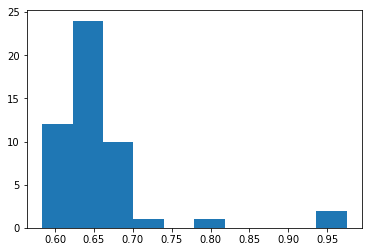

In [216]:
plt.hist(ef.module_.cis[0].mean(0).data.numpy(), bins=10)

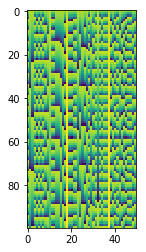

In [218]:
plt.imshow(ef.module_.cis[0].data.numpy())

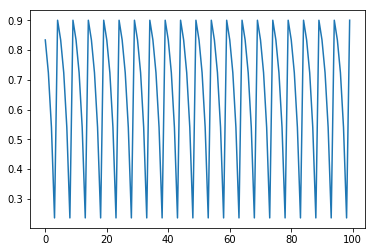

In [223]:
plt.plot(ef.module_.cis[0].data.numpy()[:, 21])

In [172]:
%pdb on
ef.fit(dataset_train)

Automatic pdb calling has been turned ON
  epoch    grad_rnn0.alpha    grad_rnn0.h2h.weight       mae_train    mae_valid     train_loss    valid_loss     dur
-------  -----------------  ----------------------  --------------  -----------  -------------  ------------  ------
      1     192514370.0871           39323640.6367  -97699488.0000      -0.3422  97699492.4063        0.3422  0.8839
      2             7.6071                  0.0095      -0.4064      -0.3421        0.4064        0.3421  0.8566
      3             7.6117                  0.0084      -0.3748      -0.3957        0.3748        0.3957  1.0116
      4             7.5623                  0.0064      -0.3410      -0.3778        0.3410        0.3778  0.9541
      5             7.4765                  0.0060      -0.3563      -0.3471        0.3563        0.3471  0.9320
      6             7.3474                  0.0047      -0.3378      -0.4158        0.3378        0.4158  0.9774
      7             7.3406                 

     68             5.5620                  0.0026      -0.3312      -0.3452        0.3312        0.3452  0.9605
     69             5.6421                  0.0020      -0.3244      -0.3398        0.3244        0.3398  0.8946
     70             5.4452                  0.0023      -0.3505      -0.3455        0.3505        0.3455  1.0424
     71             5.5876                  0.0015      -0.3222      -0.3408        0.3222        0.3408  0.9948
     72             5.5801                  0.0020      -0.3310      -0.3486        0.3310        0.3486  0.9926
     73             5.5009                  0.0018      -0.3514      -0.3427        0.3514        0.3427  0.9025
     74             5.4473                  0.0029      -0.3368      -0.3405        0.3368        0.3405  0.9491
     75             5.4062                  0.0028      -0.3133      -0.3711        0.3133        0.3711  0.9219
     76             5.4868                  0.0023      -0.3361      -0.3539        0.3361      

    141             4.6504                  0.0012      -0.3438      -0.3407        0.3438        0.3407  0.9912
    142             4.6003                  0.0019      -0.3343      -0.3642        0.3343        0.3642  0.9808
    143             4.5953                  0.0018      -0.3386      -0.3407        0.3386        0.3407  0.8991
    144             4.7265                  0.0017      -0.3203      -0.3565        0.3203        0.3565  1.0191
    145             4.8922                  0.0017      -0.3506      -0.3389        0.3506        0.3389  1.1788
    146             4.8902                  0.0012      -0.3113      -0.3433        0.3113        0.3433  0.9475
    147             4.7202                  0.0016      -0.3551      -0.3390        0.3551        0.3390  0.9951
    148             4.6215                  0.0021      -0.3424      -0.3400        0.3424        0.3400  0.9679
    149             4.6261                  0.0021      -0.3638      -0.3379        0.3638      

    213             3.2305                  0.0011      -0.3377      -0.3437        0.3377        0.3437  1.0252
    214             3.2602                  0.0029      -0.3158      -0.3649        0.3158        0.3649  0.9718
    215             3.1611                  0.0023      -0.3296      -0.3565        0.3296        0.3565  0.9523
    216             3.1579                  0.0021      -0.3156      -0.3396        0.3156        0.3396  0.9996
    217             3.1894                  0.0016      -0.3510      -0.3452        0.3510        0.3452  0.9638
    218             3.2209                  0.0027      -0.3464      -0.3621        0.3464        0.3621  0.9235
    219             3.1366                  0.0027      -0.3245      -0.3395        0.3245        0.3395  1.0576
    220             3.0818                  0.0016      -0.2979      -0.3413        0.2979        0.3413  0.9371
    221             3.0764                  0.0019      -0.3287      -0.3411        0.3287      

    283             1.8726                  0.0154      -0.2171      -0.1608        0.2171        0.1608  0.8958
    284             1.7720                  0.0098      -0.1628      -0.1673        0.1628        0.1673  1.0523
    285             1.7921                  0.0125      -0.1955      -0.3510        0.1955        0.3510  0.9050
    286             1.7387                  0.0115      -0.2039      -0.1617        0.2039        0.1617  0.9737
    287             1.6406                  0.0084      -0.1878      -0.2076        0.1878        0.2076  0.9961
    288             1.6379                  0.0109      -0.1844      -0.1969        0.1844        0.1969  0.9588
    289             1.6901                  0.0146      -0.2058      -0.2316        0.2058        0.2316  1.0532
    290             1.6639                  0.0075      -0.1783      -0.2063        0.1783        0.2063  0.9504
    291             1.7342                  0.0112      -0.1753      -0.1411        0.1753      

<class '__main__.Trainer'>[initialized](
  module_=ReconModel(
    (rnn0): DecayClocking(
      (i2h): Linear(in_features=2, out_features=50, bias=True)
      (h2h): Linear(in_features=50, out_features=50, bias=False)
      (act): ReLU()
    )
    (clf): Linear(in_features=50, out_features=1, bias=True)
  ),
)

In [184]:
np.concatenate([ef.predict(X_valid), y_valid], 1)

array([[1.0474956 , 0.79547286],
       [0.8542701 , 0.86716914],
       [1.564516  , 1.3911202 ],
       [1.1255524 , 1.013701  ],
       [1.4718798 , 1.2785041 ],
       [0.509041  , 0.4738682 ],
       [1.224097  , 1.0192541 ],
       [0.808234  , 0.55572844],
       [0.45914266, 0.07480419],
       [0.5314078 , 0.81719744],
       [1.3981222 , 1.3142273 ],
       [1.4359193 , 1.2416127 ],
       [1.1212089 , 0.9548758 ],
       [1.5672663 , 1.3978832 ],
       [1.343114  , 1.286351  ],
       [1.4190567 , 1.0775819 ],
       [1.5067025 , 1.4283104 ],
       [1.3771206 , 1.316508  ],
       [1.3919613 , 1.1983273 ],
       [1.1518785 , 0.99123746],
       [0.5431407 , 0.5903023 ],
       [1.0938053 , 0.8988619 ],
       [0.5447019 , 0.4991784 ],
       [0.6127403 , 0.7794294 ],
       [0.4917619 , 0.49408162],
       [0.81729305, 0.9017135 ],
       [1.5422534 , 1.3560486 ],
       [1.0097102 , 0.948851  ],
       [0.89686435, 1.0772424 ],
       [1.485178  , 1.1870928 ],
       [1.

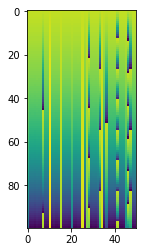

In [179]:
plt.imshow(ef.module_.cis[0].data.numpy())

In [173]:
ef.module_.rnn[0].alpha.data.numpy()

array([1.0189813 , 1.0231676 , 1.0231168 , 1.0232332 , 1.0230676 ,
       1.023154  , 1.0232557 , 1.0510173 , 1.0230806 , 1.0230485 ,
       0.9779146 , 1.0232671 , 1.0230857 , 1.0232772 , 1.0231837 ,
       1.0025064 , 1.023041  , 1.0230745 , 1.0230758 , 1.0231477 ,
       1.0179541 , 1.023173  , 1.0231779 , 1.0230105 , 1.0230421 ,
       0.9948176 , 1.0231026 , 1.0063915 , 1.1093855 , 1.02317   ,
       1.0230649 , 1.0230974 , 1.0227678 , 1.085713  , 0.99681115,
       1.0232009 , 1.0449499 , 1.0232513 , 1.0231383 , 1.0231665 ,
       1.0232688 , 1.1815759 , 1.0231942 , 1.0231616 , 1.0230664 ,
       1.0168778 , 1.1784859 , 1.0887651 , 1.0231601 , 1.0230873 ],
      dtype=float32)

In [127]:
ef.module_.rnn[0].alpha.data.numpy()

array([2.528528 , 1.863208 , 1.8984916, 2.634512 , 2.3005822, 2.6342158,
       2.312812 , 2.6757753, 2.16663  , 2.0153537, 1.5081327, 2.4720178,
       2.517074 , 1.9702799, 1.955241 , 1.9595228, 2.0289445, 2.2611926,
       1.8724318, 2.346873 , 2.460436 , 2.4603677, 2.3915648, 1.885867 ,
       2.0169554, 1.9442815, 2.140175 , 1.9311115, 2.7326508, 1.9422528,
       2.1980946, 2.6240938, 1.818188 , 2.7098432, 2.4444292, 2.5972247,
       2.6689355, 1.8738427, 2.3617902, 2.1548002, 2.4932613, 2.8023827,
       2.0932   , 2.2477942, 2.3312683, 2.5384579, 2.7993643, 2.7127936,
       2.221076 , 2.3978133], dtype=float32)

In [128]:
last_v = 0
def single_dso(alpha, ti, q=0.1):
    global last_v
    #v = dso(q * F.relu(alpha)**ti, q)
    last_v = dso(last_v * F.relu(alpha), q)
    return last_v
def series_dso(alpha, max_t, q=0.1):
    global last_v
    last_v = torch.zeros_like(alpha) + q
    return torch.stack([single_dso(alpha, ti, q) for ti in range(max_t)])

In [129]:
s = series_dso(ef.module_.rnn[0].alpha, T)
#s = series_dso(torch.autograd.Variable(torch.ones(3) + .1), T)

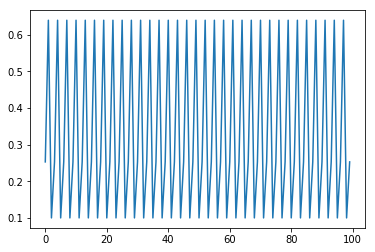

In [130]:
plt.plot(np.arange(T), s[:, 0].data.numpy())

In [685]:
ef.module_.rnn[0].alpha

Parameter containing:
 1.0184
 0.9999
 0.9908
 0.9431
 1.0106
 1.0002
 0.9219
 0.9954
 0.9989
 0.9692
 0.9988
 0.9747
 0.9549
 1.0072
 0.9886
 1.0056
 0.9881
 0.9578
 1.0123
 1.0155
 0.9897
 1.0034
 1.0011
 0.9755
 1.0054
 0.9970
 1.0081
 1.0114
 0.9651
 1.0040
 0.9998
 1.0097
 1.0092
 0.9795
 1.0106
 1.0153
 0.9837
 0.9634
 0.9739
 1.0062
 0.9849
 1.0045
 0.9783
 0.9700
 0.9737
 0.9958
 1.0136
 0.9923
 1.0166
 1.0106
[torch.FloatTensor of size 50]

In [ ]:
%pdb on
ef.fit(dataset_train)

In [377]:
ef.module_.rnn[0].speed

Parameter containing:
 3.6515
 0.3334
 0.5024
 4.1311
 2.5235
 4.1381
 2.5788
 4.3663
 1.8585
 1.0563
 0.0341
 3.3684
 3.6183
 0.8477
 0.7606
 0.7990
 1.1356
 2.3263
 0.3884
 2.7502
 3.3110
 3.3136
 2.9750
 0.4371
 1.0749
 0.7160
 1.6638
 0.6516
 4.6407
 0.6942
 2.0260
 4.0805
 0.1296
 4.5296
 3.2509
 3.9343
 4.3270
 0.3702
 2.8416
 1.7484
 3.4983
 5.0001
 1.4487
 2.2650
 2.6723
 3.7026
 4.9927
 4.5258
 2.1383
 2.9970
[torch.FloatTensor of size 50]

In [926]:
plt.plot(ef.history[:, 'grad_rnn0.period'])
plt.plot(ef.history[:, 'grad_rnn0.h2h.weight'])

KeyError: 'grad_rnn0.period'

> /home/nemo/Code/pytorch/skorch/skorch/history.py(45)partial_index()
     43         return l[idx]
     44     except KeyError as e:
---> 45         return _missingno(e)
     46 
     47 

ipdb> q


In [ ]:
o, h, c = ef.module_.rnn[0].forward(skorch.utils.to_var(X_valid[0:1], False))
c.mean(1)


In [68]:
%pdb on
ef.fit(dataset_train)

Automatic pdb calling has been turned ON
  epoch    grad_rnn0.h2h.weight    grad_rnn0.i2c.bias    grad_rnn0.i2c.weight    mae_train    mae_valid    train_loss    valid_loss     dur
-------  ----------------------  --------------------  ----------------------  -----------  -----------  ------------  ------------  ------
      1                  0.0041               -0.0000                  0.0001      -1.1061      -0.9994        1.1061        0.9994  0.7519
      2                  0.0018               -0.0000                  0.0000      -1.0034      -0.9389        1.0034        0.9389  0.7867
      3                  0.0004               -0.0000                  0.0000      -0.8550      -0.8880        0.8550        0.8880  0.7739
      4                 -0.0009                0.0001                  0.0000      -0.8316      -0.8443        0.8316        0.8443  0.7266
      5                 -0.0021                0.0000                 -0.0000      -0.8108      -0.8017        0.8108  

     52                 -0.0054                0.0001                  0.0000      -0.3268      -0.3435        0.3268        0.3435  0.7428
     53                  0.0015                0.0001                  0.0000      -0.3359      -0.3446        0.3359        0.3446  0.6850
     54                  0.0020                0.0001                  0.0000      -0.3244      -0.3432        0.3244        0.3432  0.6953
     55                 -0.0031                0.0001                  0.0000      -0.3463      -0.3461        0.3463        0.3461  0.7538
     56                 -0.0059                0.0001                  0.0000      -0.3216      -0.3478        0.3216        0.3478  0.6972
     57                  0.0080                0.0000                  0.0000      -0.3343      -0.3443        0.3343        0.3443  0.6860
     58                 -0.0066               -0.0001                 -0.0000      -0.3243      -0.3463        0.3243        0.3463  0.7484
     59             

    110                  0.0054               -0.0001                 -0.0000      -0.3494      -0.3419        0.3494        0.3419  0.6965
    111                 -0.0022               -0.0000                 -0.0000      -0.3325      -0.3413        0.3325        0.3413  0.7103
    112                  0.0006               -0.0001                 -0.0000      -0.3254      -0.3408        0.3254        0.3408  0.7367
    113                 -0.0037                0.0001                 -0.0000      -0.3129      -0.3440        0.3129        0.3440  0.6902
    114                  0.0012               -0.0001                 -0.0000      -0.3314      -0.3419        0.3314        0.3419  0.6850
    115                  0.0047               -0.0000                 -0.0000      -0.3277      -0.3406        0.3277        0.3406  0.7424
    116                  0.0059                0.0001                  0.0000      -0.3204      -0.3419        0.3204        0.3419  0.7205
    117             

    168                 -0.0001               -0.0000                 -0.0000      -0.3538      -0.3413        0.3538        0.3413  0.7005
    169                  0.0016                0.0000                 -0.0000      -0.3526      -0.3416        0.3526        0.3416  0.7390
    170                  0.0040                0.0001                  0.0000      -0.3431      -0.3391        0.3431        0.3391  0.6976
    171                  0.0018               -0.0001                 -0.0000      -0.3214      -0.3396        0.3214        0.3396  0.7023
    172                 -0.0007                0.0001                  0.0000      -0.3181      -0.3398        0.3181        0.3398  0.7480
    173                 -0.0042                0.0000                  0.0000      -0.3291      -0.3401        0.3291        0.3401  0.7324
    174                  0.0050                0.0000                 -0.0000      -0.3156      -0.3394        0.3156        0.3394  0.7386
    175             

    227                 -0.0056                0.0001                 -0.0000      -0.3358      -0.3378        0.3358        0.3378  0.7313
    228                  0.0080               -0.0000                 -0.0000      -0.3284      -0.3387        0.3284        0.3387  0.7495
    229                 -0.0016                0.0001                 -0.0000      -0.3161      -0.3390        0.3161        0.3390  0.6835
    230                 -0.0028               -0.0001                 -0.0000      -0.3187      -0.3394        0.3187        0.3394  0.7039
    231                 -0.0054               -0.0000                 -0.0000      -0.3437      -0.3398        0.3437        0.3398  0.7441
    232                  0.0003                0.0000                 -0.0000      -0.3330      -0.3398        0.3330        0.3398  0.7238
    233                 -0.0037               -0.0000                 -0.0000      -0.3019      -0.3404        0.3019        0.3404  0.6959
    234             

    285                 -0.0034                0.0001                 -0.0000      -0.3088      -0.3324        0.3088        0.3324  0.7412
    286                 -0.0037                0.0000                 -0.0000      -0.3342      -0.3341        0.3342        0.3341  0.6813
    287                 -0.0009                0.0001                  0.0000      -0.3529      -0.3349        0.3529        0.3349  0.6950
    288                  0.0013                0.0000                 -0.0000      -0.3036      -0.3342        0.3036        0.3342  0.7495
    289                 -0.0034                0.0000                 -0.0000      -0.3309      -0.3347        0.3309        0.3347  0.7047
    290                  0.0042                0.0001                 -0.0000      -0.3210      -0.3332        0.3210        0.3332  0.6852
    291                 -0.0036                0.0000                 -0.0001      -0.3364      -0.3333        0.3364        0.3333  0.7594
    292             

<class '__main__.Trainer'>[initialized](
  module_=ReconModel(
    (rnn0): GaussInputClocking(
      (i2h): Linear(in_features=2, out_features=20, bias=True)
      (h2h): Linear(in_features=20, out_features=20, bias=False)
      (i2c): Linear(in_features=2, out_features=40, bias=True)
      (act): ReLU()
    )
    (clf): Linear(in_features=20, out_features=1, bias=True)
  ),
)

In [222]:
# Gauss, non_linear
%pdb on
ef.fit(dataset_train)

Automatic pdb calling has been turned ON
    301      -0.1934      -0.1877        0.1934        0.1877  0.7240
    302      -0.1913      -0.2102        0.1913        0.2102  0.7257
    303      -0.2187      -0.1887        0.2187        0.1887  0.6993
    304      -0.2169      -0.2015        0.2169        0.2015  0.7322
    305      -0.1746      -0.1803        0.1746        0.1803  0.6708
    306      -0.2302      -0.1790        0.2302        0.1790  0.7052
    307      -0.1883      -0.2136        0.1883        0.2136  0.7708
    308      -0.1905      -0.2563        0.1905        0.2563  0.7089
    309      -0.2172      -0.1835        0.2172        0.1835  0.7486
    310      -0.1923      -0.1889        0.1923        0.1889  0.7534
    311      -0.1730      -0.1829        0.1730        0.1829  0.6661
    312      -0.2393      -0.1980        0.2393        0.1980  0.6958
    313      -0.1951      -0.1760        0.1951        0.1760  0.8033
    314      -0.1802      -0.1983        0.1802  

    410      -0.1793      -0.1572        0.1793        0.1572  0.6719
    411      -0.1552      -0.1774        0.1552        0.1774  0.7374
    412      -0.1640      -0.1500        0.1640        0.1500  0.6716
    413      -0.1656      -0.1602        0.1656        0.1602  0.6795
    414      -0.1563      -0.1517        0.1563        0.1517  0.7617
    415      -0.1514      -0.1546        0.1514        0.1546  0.6732
    416      -0.1507      -0.1540        0.1507        0.1540  0.7370
    417      -0.1273      -0.1439        0.1273        0.1439  0.7307
    418      -0.1420      -0.2791        0.1420        0.2791  0.6721
    419      -0.1291      -0.1104        0.1291        0.1104  0.7450
    420      -0.1202      -0.2021        0.1202        0.2021  0.7382
    421      -0.1487      -0.1272        0.1487        0.1272  0.7531
    422      -0.1291      -0.1215        0.1291        0.1215  0.8330
    423      -0.1420      -0.1507        0.1420        0.1507  0.6743
    424      -0.1475

    527      -0.3743      -0.3374        0.3743        0.3374  0.6940
    528      -0.2925      -0.2949        0.2925        0.2949  0.6818
    529      -0.2359      -0.2416        0.2359        0.2416  0.7248
    530      -0.2127      -0.1478        0.2127        0.1478  0.7341
    531      -0.2403      -0.2300        0.2403        0.2300  0.6874
    532      -0.1994      -0.1667        0.1994        0.1667  0.8439
    533      -0.1881      -0.2543        0.1881        0.2543  0.6789
    534      -0.1682      -0.1270        0.1682        0.1270  0.7940
    535      -0.1748      -0.3081        0.1748        0.3081  0.6930
    536      -0.1804      -0.1315        0.1804        0.1315  0.6737
    537      -0.1592      -0.1923        0.1592        0.1923  0.7467
    538      -0.1593      -0.1440        0.1593        0.1440  0.7613
    539      -0.1663      -0.1252        0.1663        0.1252  0.6744
    540      -0.1591      -0.1580        0.1591        0.1580  0.7493
    541      -0.1560

<class '__main__.Trainer'>[initialized](
  module_=ReconModel(
    (rnn0): GaussClocking(
      (i2h): Linear(in_features=2, out_features=20, bias=True)
      (h2h): Linear(in_features=20, out_features=20, bias=False)
      (act): ReLU()
    )
    (clf): Linear(in_features=20, out_features=1, bias=True)
  ),
)

In [214]:
# GRU
%pdb on
ef.fit(dataset_train)

Automatic pdb calling has been turned ON
  epoch    mae_train    mae_valid    train_loss    valid_loss     dur
-------  -----------  -----------  ------------  ------------  ------
      1      -0.4253      -0.3490        0.4253        0.3490  0.6617
      2      -0.3282      -0.3467        0.3282        0.3467  0.7477
      3      -0.3626      -0.3780        0.3626        0.3780  0.6684
      4      -0.3342      -0.3463        0.3342        0.3463  0.6761
      5      -0.3151      -0.3418        0.3151        0.3418  0.7149
      6      -0.3273      -0.3527        0.3273        0.3527  0.6505
      7      -0.3344      -0.3436        0.3344        0.3436  0.6388
      8      -0.3462      -0.3476        0.3462        0.3476  0.6379
      9      -0.3562      -0.3476        0.3562        0.3476  0.6660
     10      -0.3518      -0.3528        0.3518        0.3528  0.6914
     11      -0.3168      -0.3444        0.3168        0.3444  0.6411
     12      -0.3290      -0.3409        0.3290  

    110      -0.3374      -0.3408        0.3374        0.3408  0.6501
    111      -0.2834      -0.3255        0.2834        0.3255  0.6522
    112      -0.3048      -0.3232        0.3048        0.3232  0.6452
    113      -0.3287      -0.3423        0.3287        0.3423  0.7055
    114      -0.3070      -0.3175        0.3070        0.3175  0.6446
    115      -0.3116      -0.3110        0.3116        0.3110  0.6542
    116      -0.3077      -0.3174        0.3077        0.3174  0.6379
    117      -0.2667      -0.2557        0.2667        0.2557  0.6678
    118      -0.2945      -0.2683        0.2945        0.2683  0.6559
    119      -0.2800      -0.2511        0.2800        0.2511  0.6454
    120      -0.2742      -0.2843        0.2742        0.2843  0.6611
    121      -0.2229      -0.3733        0.2229        0.3733  0.6666
    122      -0.2371      -0.1982        0.2371        0.1982  0.6554
    123      -0.1799      -0.2043        0.1799        0.2043  0.6821
    124      -0.1963

<class '__main__.Trainer'>[initialized](
  module_=ReconModel(
    (rnn0): GRU(2, 20, batch_first=True)
    (clf): Linear(in_features=20, out_features=1, bias=True)
  ),
)

In [193]:
X_probe = np.zeros((1, T, 2), dtype='float32')
X_probe[0, 0] = np.array([0.3, 1])
X_probe[0, 1] = np.array([0.6, 1])
X_probe.shape

(1, 10, 2)

In [194]:
ef.predict(X_probe)

array([[0.847345]], dtype=float32)

In [171]:
for i, rnn in enumerate(ef.module_.rnn):
    print('rnn', i)
    for m, s in zip(rnn.m.data.tolist(), rnn.s.data.tolist()):
        print('  m: {:.4f}, s: {:.4f}'.format(m ,s))

rnn 0
  m: 0.1138, s: 0.0260
  m: 0.3739, s: 0.0480
  m: 0.5604, s: 0.0702
  m: 0.5399, s: 0.0810
  m: 1.4470, s: -0.1204
  m: 0.3176, s: 0.0442
  m: 0.3968, s: 0.0393
  m: 0.0025, s: 0.0294
  m: 0.6024, s: -0.0849
  m: 1.2013, s: 0.1277
  m: 0.2593, s: 0.0795
  m: 0.4841, s: -0.0354
  m: -0.0340, s: -0.0261
  m: 0.6357, s: -0.0111
  m: 0.6308, s: -0.1003
  m: 0.2472, s: 0.0864
  m: 0.1376, s: 0.0505
  m: -0.1138, s: -0.0340
  m: 0.9470, s: 0.0105
  m: -0.1631, s: 0.2256


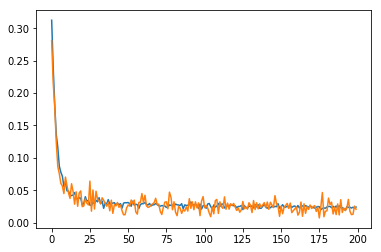

In [136]:
plt.plot(ef.history[:, 'train_loss'])
plt.plot(ef.history[:, 'valid_loss'])

In [63]:
y_pred = ef.predict(X_valid)

In [64]:
np.concatenate([y_pred, y_valid], axis=1)

array([[0.9876674 , 0.79547286],
       [0.98229325, 0.86716914],
       [0.99294883, 1.3911202 ],
       [0.9673866 , 1.013701  ],
       [0.99367166, 1.2785041 ],
       [0.9781004 , 0.4738682 ],
       [0.990951  , 1.0192541 ],
       [0.97966665, 0.55572844],
       [0.9811132 , 0.07480419],
       [0.99448556, 0.81719744],
       [0.9859924 , 1.3142273 ],
       [1.0072799 , 1.2416127 ],
       [0.99598587, 0.9548758 ],
       [0.99832904, 1.3978832 ],
       [0.9870022 , 1.286351  ],
       [1.001987  , 1.0775819 ],
       [0.9930081 , 1.4283104 ],
       [1.0375501 , 1.316508  ],
       [0.98491067, 1.1983273 ],
       [0.9632859 , 0.99123746],
       [0.970148  , 0.5903023 ],
       [0.9689887 , 0.8988619 ],
       [1.0120324 , 0.4991784 ],
       [0.95936096, 0.7794294 ],
       [0.9534509 , 0.49408162],
       [0.96946555, 0.9017135 ],
       [0.99547845, 1.3560486 ],
       [0.9759818 , 0.948851  ],
       [0.9745891 , 1.0772424 ],
       [0.99156874, 1.1870928 ],
       [0.

In [73]:
from sklearn.metrics import accuracy_score

y_pred = ef.predict_proba(X_valid)
np.concatenate([y_pred, y_valid], axis=-1)

#for i in range(pred.shape[0]):
#    plt.figure(i)
#    plt.plot(data[i].numpy())
#    plt.plot(np.arange(len(pred[i])), pred[i])

array([[1.0051842 , 1.3481964 ],
       [1.0055383 , 0.78571343],
       [1.0058323 , 1.8416321 ],
       [1.0063515 , 0.68596554],
       [1.0079416 , 0.7454061 ],
       [1.006094  , 0.9744474 ],
       [1.0057634 , 0.5680332 ],
       [1.0054916 , 0.88274145],
       [1.0135121 , 0.10493846],
       [1.0053043 , 0.60103625],
       [1.0089524 , 1.2174814 ],
       [1.0061798 , 1.5979204 ],
       [1.0086311 , 0.9718051 ],
       [1.0067388 , 0.5205229 ],
       [1.0061386 , 1.1977131 ],
       [1.0067934 , 0.55742234],
       [1.0145633 , 0.86927325],
       [1.0063804 , 1.3813243 ],
       [1.0048752 , 0.6484526 ],
       [1.0093043 , 0.74386305],
       [1.006612  , 1.4304361 ],
       [1.0047089 , 1.2362072 ],
       [1.0106745 , 0.8784754 ],
       [1.0063356 , 0.1613566 ],
       [1.0088357 , 1.4821553 ],
       [1.0058767 , 1.2995601 ],
       [1.0088131 , 0.7260798 ],
       [1.0043812 , 0.6362765 ],
       [1.0130583 , 1.3053422 ],
       [1.0073383 , 1.4645123 ],
       [1.